# **Soil Texture Classification using Deep Learning**

# Initial Prepration

In [1]:
training_data_directory = '/content/drive/MyDrive/soil_photos/train'
test_data_directory = '/content/drive/MyDrive/soil_photos/test'

In [2]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [3]:
file = '/content/drive/MyDrive/soil_photos'

In [5]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256 ,256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 76 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


# Model Building

In [6]:
# choose model parameters
num_conv_layers = 2
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [7]:
# Initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convolutional layer
model.add(Conv2D(layer_size, (3, 3), input_shape=(256,256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# add output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'],
                )

# use the data already loaded previously to train/tune the model
model.fit(training_data,
            epochs=num_training_epochs,
            validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/20
3/3 [==============================] - 38s 16s/step - loss: 3.2240 - accuracy: 0.3553 - val_loss: 2.3224 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 11s 5s/step - loss: 1.5986 - accuracy: 0.3289 - val_loss: 1.3592 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 15s 6s/step - loss: 1.2253 - accuracy: 0.3289 - val_loss: 1.1691 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 10s 2s/step - loss: 1.1241 - accuracy: 0.3289 - val_loss: 1.1146 - val_accuracy: 0.3333
Epoch 5/20
3/3 [==============================] - 10s 3s/step - loss: 1.1113 - accuracy: 0.3553 - val_loss: 1.1009 - val_accuracy: 0.0667
Epoch 6/20
3/3 [==============================] - 10s 3s/step - loss: 1.0980 - accuracy: 0.3289 - val_loss: 1.0957 - val_accuracy: 0.3333
Epoch 7/20
3/3 [==============================] - 10s 2s/step - loss: 1.0950 - accuracy: 0.3421 - val_loss: 1.0862 - val_accuracy: 0.3333
Epoch 8/20
3/3 [=================

# Model Testing

In [9]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256,256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = ["Gravel", "Sand", "Silt","other"] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    #true_value = re.search(r'(Gravel)|(Sand)|(Silt)|(other)', image_fp)[0]

    out = f"""Predicted Soil Type: {predicted_value}
   """

    return out

1/1 [==============================] - 0s 42ms/step
Predicted Soil Type: Gravel
   


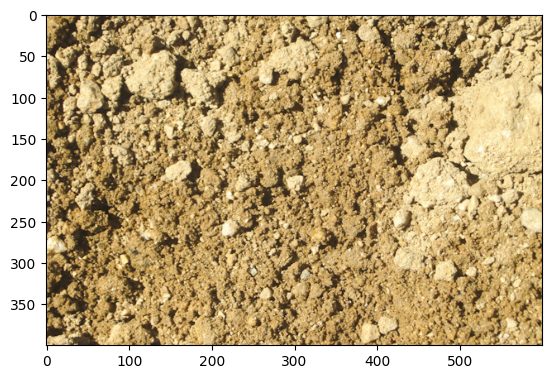

In [26]:
test_image_filepath = '/content/drive/MyDrive/soil_photos/test_image.jpg'
print(make_prediction(test_image_filepath))

# Percentage based Classification

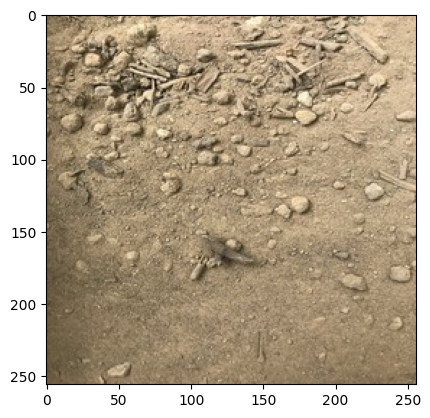

In [13]:
percentage_photo = test_data_directory + r"/Silt/5.jpg"
im = cv2.imread(percentage_photo) # load image
plt.imshow(im[:,:,[2,1,0]])

# Data Manipulation

In [14]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for classification in classification_list:
        folder = image_dir + '/' + classification + '/'
        save_folder = save_dir + '/' + classification + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape
            im_dim = 64
            # For cropping images
            for r in range(0,img.shape[0],im_dim):
                for c in range(0,img.shape[1],im_dim):
                    cropped_img = img[r:r+im_dim, c:c+im_dim,:]
                    ch, cw, cc = cropped_img.shape
                    if ch == im_dim and cw == im_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path,cropped_img)
                    else:
                        pass

In [15]:
try:
    parent = training_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ["Gravel", "Sand", "Silt"]
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training images
    split_images(image_dir=training_data_directory,
                save_dir=training_data_directory.replace('train', 'train_divided'))
    # split test images
    split_images(image_dir=test_data_directory,
                save_dir=test_data_directory.replace('test', 'test_divided'))
except FileExistsError:
    pass

# Load Model

In [16]:
model_fp = os.getcwd()+'/'+'soil.h5'
print(model_fp)
model = load_model(model_fp)

/content/soil.h5


# Classify Images

In [17]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img,(1024,1024))
    im_dim = 256

    for r in range(0, img.shape[0], im_dim):
        for c in range(0, img.shape[1], im_dim):
            cropped_img = img[r:r + im_dim, c:c + im_dim, :]
            h, w, c = cropped_img.shape
            if h == im_dim and w == im_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
            else:
                continue
    total_count = gravel_count + sand_count + silt_count
    proportion_array = [gravel_count / total_count, sand_count / total_count, silt_count / total_count]
    return proportion_array


def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 255.
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = classes[first_idx]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model=model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2, 1, 0]])

    print(f'''---
Percent Gravel: {round(out[0] * 100, 2)}%)
Percent Sand: {round(out[1] * 100, 2)}%)
Percent Silt: {round(out[2] * 100, 2)}%)
Time to Classify: {finish} seconds
---''')

# Test Run

1/1 [==============================] - 0s 42ms/step
---
Percent Gravel: 93.75%)
Percent Sand: 6.25%)
Percent Silt: 0.0%)
Time to Classify: 2.68032 seconds
---


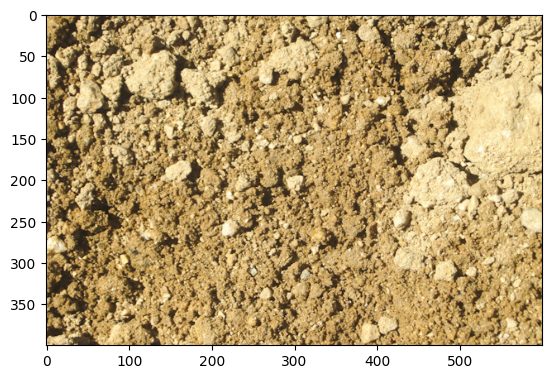

In [25]:
classify_percentage(image_fp='/content/drive/MyDrive/soil_photos/test_image.jpg')

Both approaches to soil classification have advantages. For example, classifying the entire image is faster. However, percentage classification is more computationally expensive but provides more information and may be a better representation of the true classification.